In [1]:
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.5 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c hatenorm23
! unzip /content/hatenorm23.zip

Saving kaggle.json to kaggle.json
  0% 0.00/195k [00:00<?, ?B/s]
100% 195k/195k [00:00<00:00, 91.6MB/s]
Archive:  /content/hatenorm23.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
import os
import copy
import datasets
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from datasets import load_dataset
from collections import Counter

In [4]:
df_train = pd.read_csv("/content/train.csv", sep='|')
df_test = pd.read_csv("/content/test.csv", sep='|')

In [5]:
df_train.head()

,Id,sentence,span,bio
0,0,"Say it loud , say it clear , illegal #immigran...","{'start': [8, 9], 'end': [8, 9]}",O O O O O O O O B I O O O O O
1,1,"Islam is not a religion, its just an excuse fo...","{'start': [0, 10], 'end': [4, 13]}",B I I I I O O O O O B I I I O O O O
2,2,@user Care About Illegals Breaking U.S #Immigr...,"{'start': [40], 'end': [40]}",O O O O O O O O O O O O O O O O O O O O O O O ...
3,3,Behold the future DACA America - unless we Man...,"{'start': [10, 17], 'end': [14, 18]}",O O O O O O O O O O B I I I I O O B I O O O O ...
4,4,No that little tattoo of a flower on your ankl...,"{'start': [14, 20, 25, 26], 'end': [14, 21, 25...",O O O O O O O O O O O O O O B O O O O O B I O ...


In [6]:
mapping_to_int = {
    'B': 0,
    'I': 1,
    'O': 2
}

In [7]:
bios = df_train['bio'].to_list()
for i in range(len(bios)):
    bio = bios[i]
    for k in mapping_to_int.keys():
        bio = bio.replace(k, str(mapping_to_int[k]))
    bio = bio.split()
    for j in range(len(bio)):
        bio[j] = int(bio[j])
    bios[i] = bio
df_train['ner_tags'] = bios

In [8]:
sentences = df_train['sentence'].to_list()
for i in range(len(sentences)):
    sentence = sentences[i]
    sentence = sentence.split()
    sentences[i] = sentence
df_train['tokens'] = sentences

In [9]:
for i, j in zip(df_train['tokens'].to_list(), df_train['ner_tags'].to_list()):
    if len(i) != len(j):
        print(i,j)

In [10]:
df_main = copy.deepcopy(df_train)

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_eval = train_test_split(df_train, test_size=0.2, random_state=42)

In [12]:
df_train = df_train[['Id', 'ner_tags', 'tokens']]
df_eval = df_eval[['Id', 'ner_tags', 'tokens']]
df_main = df_main[['Id', 'ner_tags', 'tokens']]

df_train

,Id,ner_tags,tokens
807,807,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ...","[@user, @user, TRAVEL, ADVISORYDominic, Durden..."
281,281,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, ...","[Wow, ,, Stupid, is, as, Stupidity, does, Thes..."
1463,1463,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, ...","[@user, @user, ,, you, don't, have, to, be, a,..."
1764,1764,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, ...","[the, fucking, kike, sob, banned, my, favorite..."
1746,1746,"[2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, ...","[The, British, politicians, want, to, impose, ..."
...,...,...,...
1638,1638,"[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[Jews, are, not, only, insane, ,, they, are, o..."
1095,1095,"[0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 2, 2, ...","[Rape, charges, isnt, the, way, to, get, reven..."
1130,1130,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[Quite, strange,, the, majority, of, Easter, E..."
1294,1294,"[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ...","[Was, getting, elbowed, by, a, triple, chinned..."


In [13]:
train_dataset = datasets.Dataset.from_pandas(df_train)
eval_dataset = datasets.Dataset.from_pandas(df_eval)

ds = datasets.Dataset.from_pandas(df_main)

In [14]:
ds.features

{'Id': Value(dtype='int64', id=None),
 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [15]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [16]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [75]:
class NERModelWithBiLSTM(keras.Model):
    def __init__(self, num_layers, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32):
        super(NERModelWithBiLSTM, self).__init__()
        self.num_layers = num_layers
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_blocks = [
            keras.Sequential(
                [
                    TransformerBlock(embed_dim, num_heads, ff_dim),
                    layers.Dropout(0.2),
                ]
            ) for _ in range(self.num_layers)
        ]
        self.bilstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))  # Add a Bi-LSTM layer
        self.dropout1 = layers.Dropout(0.2)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.2)
        self.ff_2 = layers.Dense(256, activation="relu")
        self.dropout3 = layers.Dropout(0.2)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = self.bilstm(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_2(x)
        x = self.dropout3(x, training=training)
        x = self.ff_final(x)
        return x

In [76]:
def export_to_file(export_file_path, data):
    with open(export_file_path, "w") as f:
        for record in data:
            ner_tags = record["ner_tags"]
            tokens = record["tokens"]
            if len(tokens) > 0:
                f.write(
                    str(len(tokens))
                    + "\t"
                    + "\t".join(tokens)
                    + "\t"
                    + "\t".join(map(str, ner_tags))
                    + "\n"
                )

if not os.path.exists("data"):
    os.mkdir("data")
    export_to_file("./data/ds.txt", ds)
    export_to_file("./data/conll_val.txt", eval_dataset)

In [77]:
mapping = {
    0: '[PAD]',
    1: 'B',
    2: 'I',
    3: 'O'
}

In [78]:
all_tokens = sum(ds["tokens"], [])
all_tokens_array = np.array(list(map(str.lower, all_tokens)))

counter = Counter(all_tokens_array)
print(len(counter))

num_tags = len(mapping)
vocab_size = 20000

vocabulary = [token for token, count in counter.most_common(vocab_size - 2)]

lookup_layer = keras.layers.StringLookup(
    vocabulary=vocabulary
)

8165


In [79]:
train_data = tf.data.TextLineDataset("./data/ds.txt")
val_data = tf.data.TextLineDataset("./data/conll_val.txt")

In [80]:
def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags


def lowercase_and_convert_to_ids(tokens):
    tokens = tf.strings.lower(tokens)
    return lookup_layer(tokens)


batch_size = 32
train_dataset = (
    train_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)

In [81]:
class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction=keras.losses.Reduction.NONE
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


loss = CustomNonPaddingTokenLoss()

In [82]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [83]:
# ner_model = NERModel(num_layers=6, num_tags=num_tags, vocab_size=vocab_size, embed_dim=32, num_heads=4)
# ner_model.compile(optimizer='adam', loss=loss)

In [93]:
ner_model = NERModelWithBiLSTM(num_layers=6, num_tags=num_tags, vocab_size=vocab_size, embed_dim=32, num_heads=4)
ner_model.compile(optimizer='adam', loss=loss)

In [94]:
h = ner_model.fit(train_dataset, epochs=15)

Epoch 1/15
76/76 [==============================] - 44s 227ms/step - loss: 0.6458
Epoch 2/15
76/76 [==============================] - 3s 37ms/step - loss: 0.5952
Epoch 3/15
76/76 [==============================] - 3s 37ms/step - loss: 0.5931
Epoch 4/15
76/76 [==============================] - 3s 38ms/step - loss: 0.5905
Epoch 5/15
76/76 [==============================] - 3s 42ms/step - loss: 0.5216
Epoch 6/15
76/76 [==============================] - 3s 37ms/step - loss: 0.4059
Epoch 7/15
76/76 [==============================] - 3s 42ms/step - loss: 0.3439
Epoch 8/15
76/76 [==============================] - 3s 38ms/step - loss: 0.3038
Epoch 9/15
76/76 [==============================] - 3s 37ms/step - loss: 0.2876
Epoch 10/15
76/76 [==============================] - 3s 37ms/step - loss: 0.2501
Epoch 11/15
76/76 [==============================] - 4s 51ms/step - loss: 0.2330
Epoch 12/15
76/76 [==============================] - 3s 38ms/step - loss: 0.2332
Epoch 13/15
76/76 [================

<ipython-input-95-733feeca9a3b>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


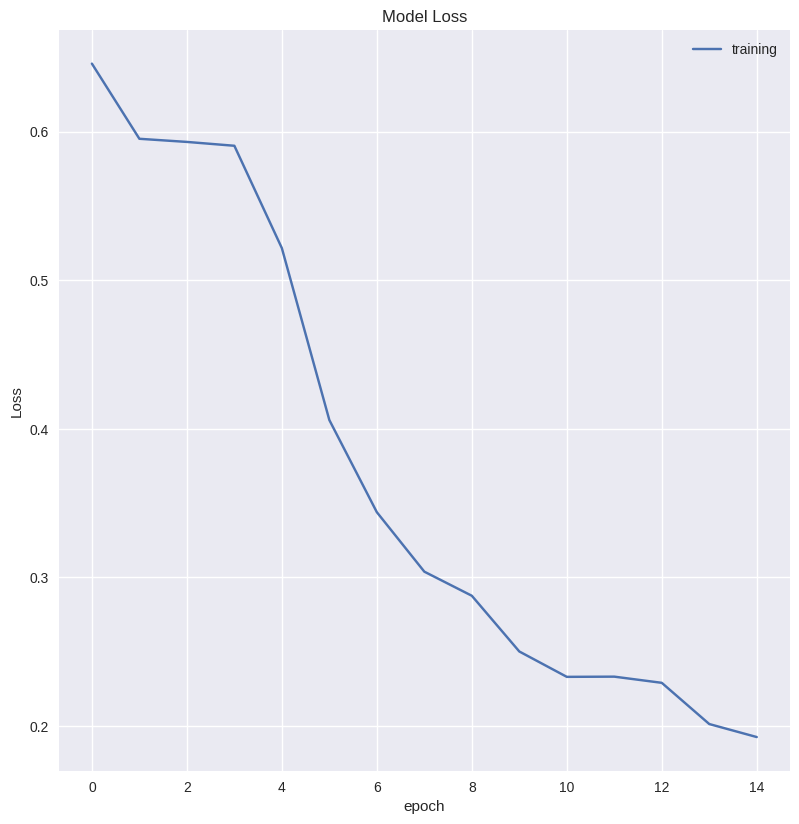

In [95]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")

def display_training_curves(training, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training'])

plt.subplots(figsize=(8,8))
plt.tight_layout()
display_training_curves(h.history['loss'], 'Loss', 111)

In [113]:
ner_model.save_weights("ner_tr_bilstm_weights.h5")

# Inference

In [96]:
def switch_to_I_if_needed(labels):
    switched_labels = []
    prev_label = None

    for i, label in enumerate(labels):
        if i == 0 and label == 'I':
            switched_labels.append('B')
        elif label == 'B' and prev_label in ['B', 'I']:
            switched_labels.append('I')
        elif label == 'I' and prev_label == 'O':
            switched_labels.append('B')
        else:
            switched_labels.append(label)

        prev_label = label

    return switched_labels

In [97]:
def custom_pipeline(text, ner_model=ner_model, mapping=mapping):
    def tokenize_and_convert_to_ids(text):
        tokens = text.split()
        return lowercase_and_convert_to_ids(tokens)

    sample_input = tokenize_and_convert_to_ids(text)
    sample_input = tf.reshape(sample_input, shape=[1, -1])

    output = ner_model.predict(sample_input)
    prediction = np.argmax(output, axis=-1)[0]
    prediction = [mapping[i] for i in prediction]

    switched_labels = switch_to_I_if_needed(prediction)

    return switched_labels

In [98]:
custom_pipeline(text="i hate muslim niggers but love cute animals. bitch rapefugee nigger nigger negro nigger #WomenSuck")

1/1 [==============================] - 1s 1s/step


['O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I']

In [99]:
test_sentences = df_test['sentence'].values
test_sentences[:10]

array(['Has the penny , or should I say peseta , finally dropped ? Can they now see that individual Nations dona t want to be overrun by immigrants whose a Eœculturea is alien to our own ? Push too far and we push back ! @user ',
       'it painfully clear why mudslime throw these people off rooftops',
       'says the kike cunt trying to charge for premium content how that working for you obviously nobody gives a fuck what you have to say cuz you are a fucking joke go blow some wetbacks behind the burrito stand and you might make a buck lick balls heebhole premium cunt contributor',
       'Well The Hoes might pull this off . Pardon the pun ! #mkr',
       'All of our tim hortons are staffed by those people and every single town is full of those people .',
       'Pakis are all about forcing their culture on us .',
       'Islam is a just a repressive ideology that persecutes women and gay people.',
       'fast nigger wants to drive fass see ya at the next red light nigga',
       '@

In [100]:
from tqdm.notebook import tqdm

In [101]:
sentences = df_test['sentence'].to_list()
for i in range(len(sentences)):
    sentence = sentences[i]
    sentence = sentence.split()
    sentences[i] = sentence
df_test['tokens'] = sentences
text = df_test['tokens'].to_list()

In [102]:
df_test['sentence'].values

array(['Has the penny , or should I say peseta , finally dropped ? Can they now see that individual Nations dona t want to be overrun by immigrants whose a Eœculturea is alien to our own ? Push too far and we push back ! @user ',
       'it painfully clear why mudslime throw these people off rooftops',
       'says the kike cunt trying to charge for premium content how that working for you obviously nobody gives a fuck what you have to say cuz you are a fucking joke go blow some wetbacks behind the burrito stand and you might make a buck lick balls heebhole premium cunt contributor',
       'Well The Hoes might pull this off . Pardon the pun ! #mkr',
       'All of our tim hortons are staffed by those people and every single town is full of those people .',
       'Pakis are all about forcing their culture on us .',
       'Islam is a just a repressive ideology that persecutes women and gay people.',
       'fast nigger wants to drive fass see ya at the next red light nigga',
       '@

In [103]:
ls = []
for i in tqdm(range(len(df_test['sentence'].values))):
    t = custom_pipeline(text=df_test['sentence'].values[i])
    ls.append(t)

  0%|          | 0/606 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


In [104]:
outputs = []
for pred in ls:
    output = []
    for i in pred:
        if len(i) == 0:
            output.append('O')
        else:
            output.append(i)
    outputs.append(output)

In [105]:
for i in range(len(outputs)):
    outputs[i] = " ".join(outputs[i])

In [106]:
outputs[:10]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O B O O O O B O O O O O O O O O O O O O',
 'O O O O B O O O O O',
 'O O B I O O O O O O O O O O O O O B I I O O O O O O O O O B O O O O O O O O O O O O O O O O O O O B O',
 'O O B O O O O O O O O O B',
 'O O O O O O O O O O O O O O O B O O O O',
 'B O O O B O O O O O',
 'B O O O O O B I I I I I I',
 'O B O O O O O O O O O O O B',
 'O O O O B O O O O O O O B O O O O O O B O O O O O O O O O O O O O O B',
 'O O O O O O O O O B I O O O O O O O O O O B O O O O O O O O']

In [108]:
df_test['bio'] = outputs
df_submission = df_test[['Id', 'bio']]
df_submission.to_csv('df25.csv', index=False)

In [110]:
def observe_errors(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        output = ner_model.predict(x)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]
    return predicted_tags, real_tags

In [111]:
y_pred, y_true = observe_errors(eval_dataset)

1/1 [==============================] - 0s 32ms/step


In [112]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           B       0.79      0.81      0.80      4077
           I       0.77      0.89      0.83      5339
           O       0.98      0.96      0.97     44628

    accuracy                           0.94     54044
   macro avg       0.85      0.89      0.87     54044
weighted avg       0.95      0.94      0.94     54044

